In [1]:
from collections import Counter
import functools
import itertools as it
import os
import re
import string

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

from utils import *
from topic_utils import *

In [61]:
pd.set_option('display.max_colwidth', 50)

# reproducible rng
seed = 0

plt.style.use("bmh")
%matplotlib inline

# suppress stop words mismatch warning
import warnings
warnings.simplefilter('ignore')

### Data

In [3]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

In [62]:
user_tweets = (campaign
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              )
user_tweets.head(5)

,tweet_text
userid,
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=,[America and the way its government treats its...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=,[@ManotoNews اگه ایران به یمن و مقاومت کمک نکن...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=,[People are not silent! This structure must ch...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=,[El pueblo indígena Kayapo cerró una important...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=,[@VoteMarsha Why Women Prefer to Vote for an r...


### Vectorize

In [5]:
stop_words = [*stopwords.words(),
              '[url]', '[at]', '[htag]',
             ]
tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
preprocess_partial = functools.partial(preprocess_string, special_tokens=False)

vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                             max_features=2000,
                            )

In [6]:
documents_list = (user_tweets['tweet_text']
                  .map(long_string)
                  .map(preprocess_string)
                   )

In [7]:
matrix = vectorizer.fit_transform(documents_list)

## Clustering

In [28]:
def k_means_cluster(matrix, k):

    print('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(matrix)
    labels = model.labels_
    metrics = silhouette_score(matrix, labels), model.inertia_)
            
    return model, metrics

In [29]:
model, metrics = k_means_cluster(matrix, k)

fitting model for 10 clusters


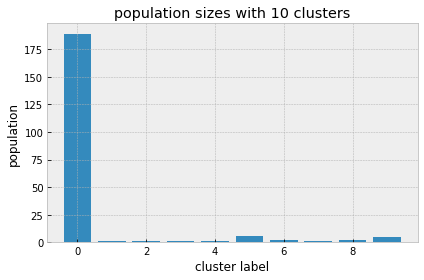

In [30]:
fig, ax = plt.subplots()

ax.bar(range(len(set(model.labels_))), np.bincount(model.labels_))

ax.set_ylabel('population')
ax.set_xlabel('cluster label')
ax.set_title('population sizes with {} clusters'.format(ks[0]))
    
fig.tight_layout()

Users are grouped into 10 clusters based on the contents of their tweets.

In [64]:
user_tweets['cluster'] = model.labels_

Cluster sizes:

In [65]:
sizes = (user_tweets
       .groupby('cluster')
       .size()
       .sort_values(ascending=False)
       )
sizes

cluster
0    189
5      6
9      5
8      2
6      2
7      1
4      1
3      1
2      1
1      1
dtype: int64

In [66]:
idx = sizes.index[0]

top_cluster = (user_tweets
           .groupby('cluster')
           .get_group(idx)['tweet_text']
           .apply(long_string)
          )
top_cluster.head(5)

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     America and the way its government treats its ...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    @ManotoNews اگه ایران به یمن و مقاومت کمک نکنه...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    People are not silent! This structure must cha...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     El pueblo indígena Kayapo cerró una importante...
1099221870530961408                             Droit de vote à 16ans, vous êtes ?\nEt pourquo...
Name: tweet_text, dtype: object

In [49]:
cluster_ids = (top_cluster
              .reset_index()['userid'])

In [54]:
cols = ['user_screen_name',
        'user_reported_location',
        'user_profile_description',
        'account_language']

In [56]:
user_info = (campaign_users
            .loc[campaign_users.index.isin(cluster_ids)])
user_info[cols].sample(10)

,user_screen_name,user_reported_location,user_profile_description,account_language
userid,,,,
djt7FLKLI76zIdPZHvdLNKMth8pEH8+zHauTj5wBc8=,djt7FLKLI76zIdPZHvdLNKMth8pEH8+zHauTj5wBc8=,<NA>,Trump Lover life long Republican #MAGA Twitter Should Accept Us,en
POFiKF8W0EqwLSW0u9wkB0SzWEEQfgH5S5woQyd06U=,POFiKF8W0EqwLSW0u9wkB0SzWEEQfgH5S5woQyd06U=,Venezuela,<NA>,en
MHqZeUH+YkUtFTsWzyngLv7XTBXmGQP7JsuRP9eVXk=,MHqZeUH+YkUtFTsWzyngLv7XTBXmGQP7JsuRP9eVXk=,Maine,women rights activist #blacklivesmatters #humanlivesmatters,en
uA73TTeDiYFMngplc4rK+AvquWpIfpMbH9iVB8lMA=,uA73TTeDiYFMngplc4rK+AvquWpIfpMbH9iVB8lMA=,World Citizen,No one important #FBR #resistor New here HATE TRUMP,en
HcrkAj2Z5laESkAd3aQjE1dgoP6r9xDN6LLzEIHzX4=,HcrkAj2Z5laESkAd3aQjE1dgoP6r9xDN6LLzEIHzX4=,"Georgia, USA",I want to create a new world for myself. #resist #voteblue,fa
j80DmPyr+XN8jvSDIBdwlTdMSxAR6toJYrlEdvba0=,j80DmPyr+XN8jvSDIBdwlTdMSxAR6toJYrlEdvba0=,IN A DILEMMA,ما را به سخت جانی خود این گمان نبود… دکتری هستم در منتهای شش گوشگی,en
DsqKOBIbyhdb1fRCREnRRabr2ijPMzNgximA+u8N8=,DsqKOBIbyhdb1fRCREnRRabr2ijPMzNgximA+u8N8=,<NA>,power and resistance in the middle east✊ #RESISTANCE,en
23vaC1gG734g7FYBCL66wVv4Z5k1I48mYXwAWmwsa1E=,23vaC1gG734g7FYBCL66wVv4Z5k1I48mYXwAWmwsa1E=,<NA>,The Alternative World website is where you could be able to find different point of views about how today's world should be changed so as to be be...,en
9kflcfCItXKfXoFIbazwmpD0KxF9AGotIq+6iRHpQc=,9kflcfCItXKfXoFIbazwmpD0KxF9AGotIq+6iRHpQc=,<NA>,#resist,en


This word cloud shows the frequent word tokens used by users in the largest cluster:

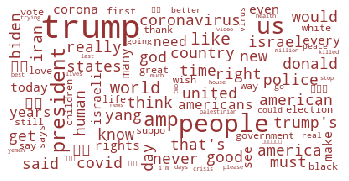

In [33]:
fig = vis_from_series(top_cluster)

In [43]:
idx = sizes.index[1]

cluster = (user_tweets
           .groupby('cluster')
           .get_group(idx)['tweet_text']
           .apply(long_string)
          )
cluster.head(5)

userid
6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=      Sungguh bodoh orang yang tidak mau membela bangsa madhlum seperti bangsa Palestina.\n#PalestineWillBeFree \n#Palestine https://t.co/Jypm4OqLXJ Sem...
79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=    god will punish you Aung San Suu Kyi #ShameOnAungSanSuuKyi https://t.co/n2sxv4RWKs From this \nBanana\nBanana\n to this \nBoxing glove\nGhost\n\n#...
BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=      the camps which have been thought to be places of detention, are actually centers of education aimed at deradicalization efforts and teaching voca...
ihPCMQ32xEzpD35Et9IH4HO21XKiWdSJreVg+pHT5o=     #Palestine \n#PalestineWillBeFree \n#PalestineResistance \n#COVIDー19 \n#Ramadhan thanks god #BanggaJadiMuslim siapa yang ngerasa gini juga? https:...
rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=      #GoodThingsComeToThoseWho follow the supreme religious authority Pemimpin Revolusi Islam Ayatullah Sayyid Ali Khamenei mendesak pembantaian umat I...
Nam

Second-largest cluster:

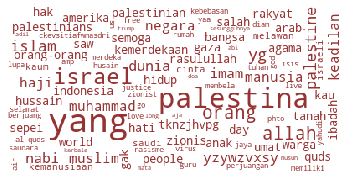

In [44]:
fig = vis_from_series(cluster)